In [52]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from data_generation.data_generator_main import run_data_simulations
from data_generation.data_simulator import IndividualDataSimulator
from data_generation.network_generator import GraphGenerator, NetworkFeatureExtractor
from constants import NetworkSettings, DataGenerationSettings
from methods.methods_est import LinearRegressionEstimator
from methods.visualization import ResultsPlotter, plot_result_graphs, plot_fpr_by_method, plot_bias_with_corruption_overlay
from data_generation.data_simulator import IndividualDataSimulator
from methods.methods_est import PropensityScoreMatcher


from methods.visualization import plot_result_graphs_multiple_influence

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
# initialization 

network_settings = NetworkSettings()
dgp_settings = DataGenerationSettings()
lr_estimator = LinearRegressionEstimator()
lr_estimator_0 = LinearRegressionEstimator(outcome_name="outcome_zero")

feature_adj_sets = network_settings.feature_adj_sets
network_configs = network_settings.networks_types
neighbour_influences = dgp_settings.n_influence_list

In [68]:
assignment_type = "random"

results = defaultdict(lambda: defaultdict(dict))
all_results_df = pd.DataFrame()
for network_type, p_edges in tqdm(network_configs):
    for influence in neighbour_influences:
        file_path = f"./src/simulation_results/sim_{assignment_type}_{network_type}_influence{influence}.pkl"
        
        with open(file_path, "rb") as f:
            data = pickle.load(f)

        results_dict = defaultdict(lambda: {
            "pvalue": [], "coef": [], "bias": [],
            "pvalue_0": [], "coef_0": [], "bias_0": []
        })

        individual_data_simulator = IndividualDataSimulator(
                n_nodes=network_settings.n_nodes,
                n_features=network_settings.n_features,
                error_mean=dgp_settings.error_mean,
                error_std=dgp_settings.error_std,
                beta_mean=dgp_settings.beta_mean,
                beta_std=dgp_settings.beta_std,
                share_treatment=dgp_settings.share_treatment,
                group_assignment_type="random"
            )
            
        for i_sim in range(dgp_settings.n_sim):
            individ_data_sim = data[i_sim]["individ_data"]
            beta = individual_data_simulator.generate_random_beta_matrix()
            error = individual_data_simulator.generate_random_error()
            covariates = individ_data_sim[["covariate_0", "covariate_1"]].to_numpy()
            outcome_zero = individual_data_simulator.generate_SAR_outcome(
                                adj_matrix=data[i_sim]["adj_matrix"],
                                neighbour_influence=influence,
                                group_assignment=individ_data_sim["group"].tolist(),
                                beta=beta,
                                covariates=covariates,
                                error=error,
                                treatment_effect=0
                            )
            individ_data_sim["outcome_zero"] = outcome_zero
            for feature_set, features in feature_adj_sets.items():
                coef, pvalue = lr_estimator.calculate_results(
                    individ_data=individ_data_sim,
                    additional_feature_names=features
                )
                results_dict[feature_set]["pvalue"].append(pvalue)
                results_dict[feature_set]["coef"].append(coef)
                results_dict[feature_set]["bias"].append(coef - 0.3)

                coef_0, pvalue_0 = lr_estimator_0.calculate_results(
                    individ_data=individ_data_sim,
                    additional_feature_names=features
                )
                results_dict[feature_set]["pvalue_0"].append(pvalue_0)
                results_dict[feature_set]["coef_0"].append(coef_0)
                results_dict[feature_set]["bias_0"].append(coef_0 - 0)

        results[network_type][influence] = dict(results_dict)

        for feature_set, features in feature_adj_sets.items():
            results_plotter = ResultsPlotter(
                estimated_effect=results_dict[feature_set]["coef"],
                true_effect=dgp_settings.treatment_effect_mean,
                network_type=network_type,
                assignment_type=assignment_type,
                neighbour_influence=influence,
                additional_feature_names=features,
                bias_statistics=results_dict[feature_set]["bias"],
                pvalues=results_dict[feature_set]["pvalue_0"]
            )
            results_plotter.calculate_results()
            results_df = results_plotter.create_results()
            results_plotter.create_effect_estimation_plots()
            all_results_df = pd.concat([all_results_df, results_df], ignore_index=True)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [01:24<00:00, 28.23s/it]


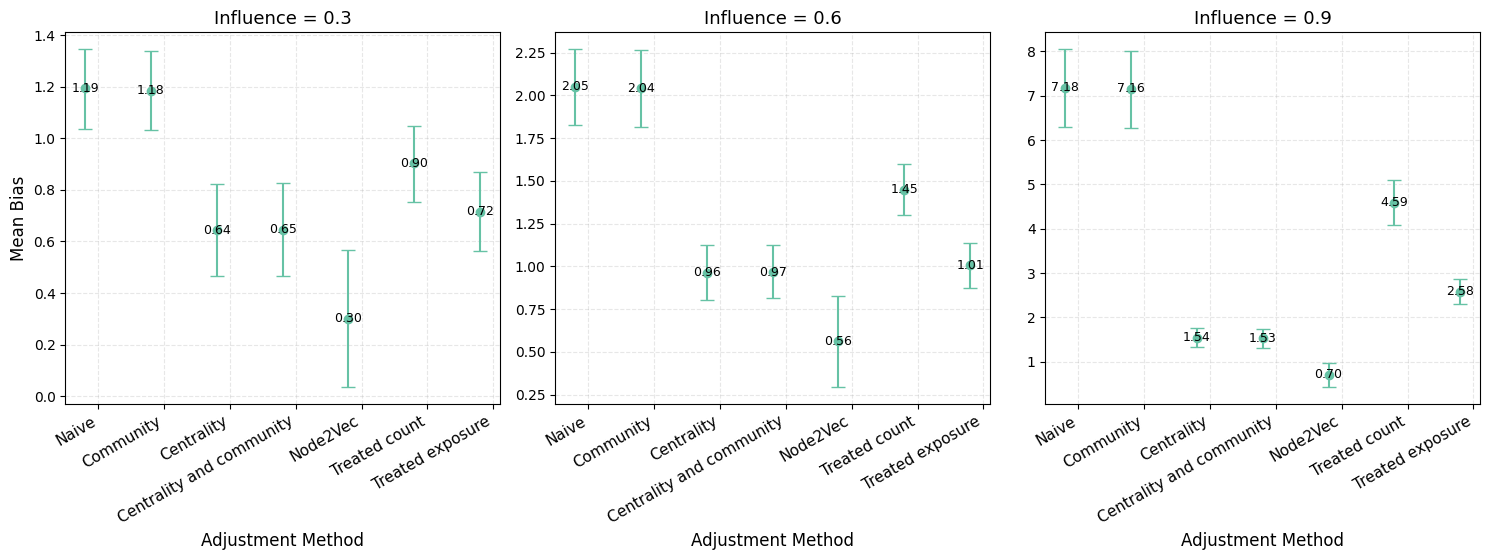

In [53]:
plot_result_graphs_multiple_influence(all_results[all_results["Network"] == "barabasi_albert_graph"])

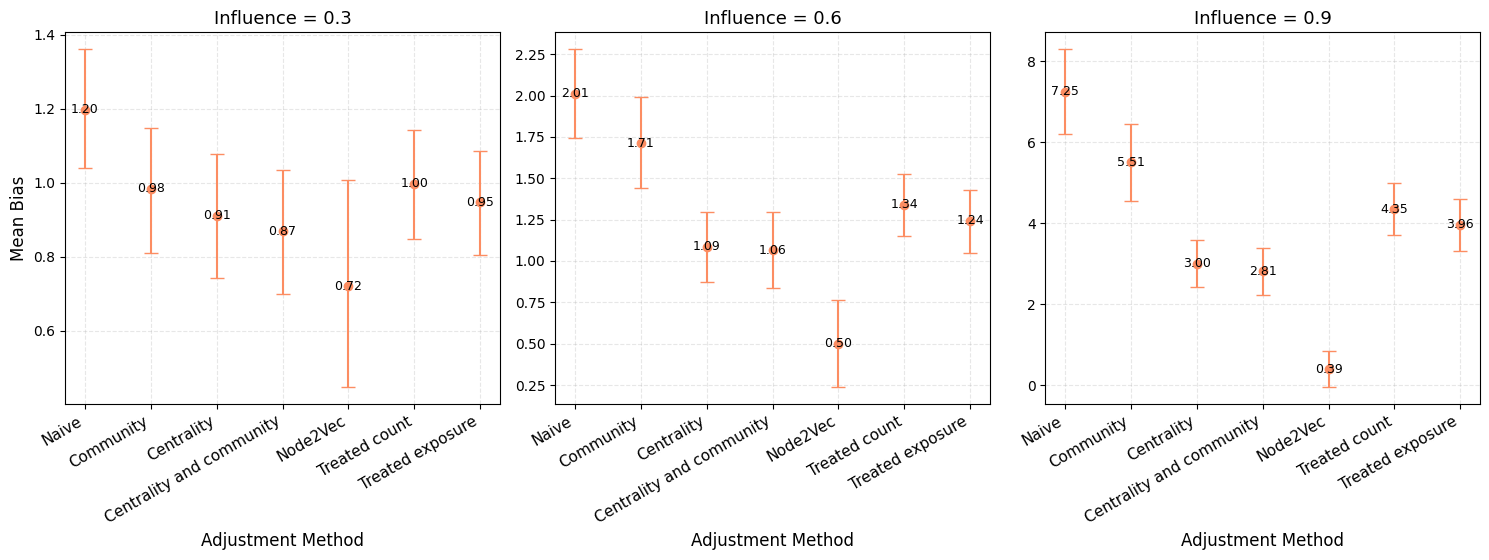

In [54]:
plot_result_graphs_multiple_influence(all_results[all_results["Network"] == "watts_strogatz_graph"])

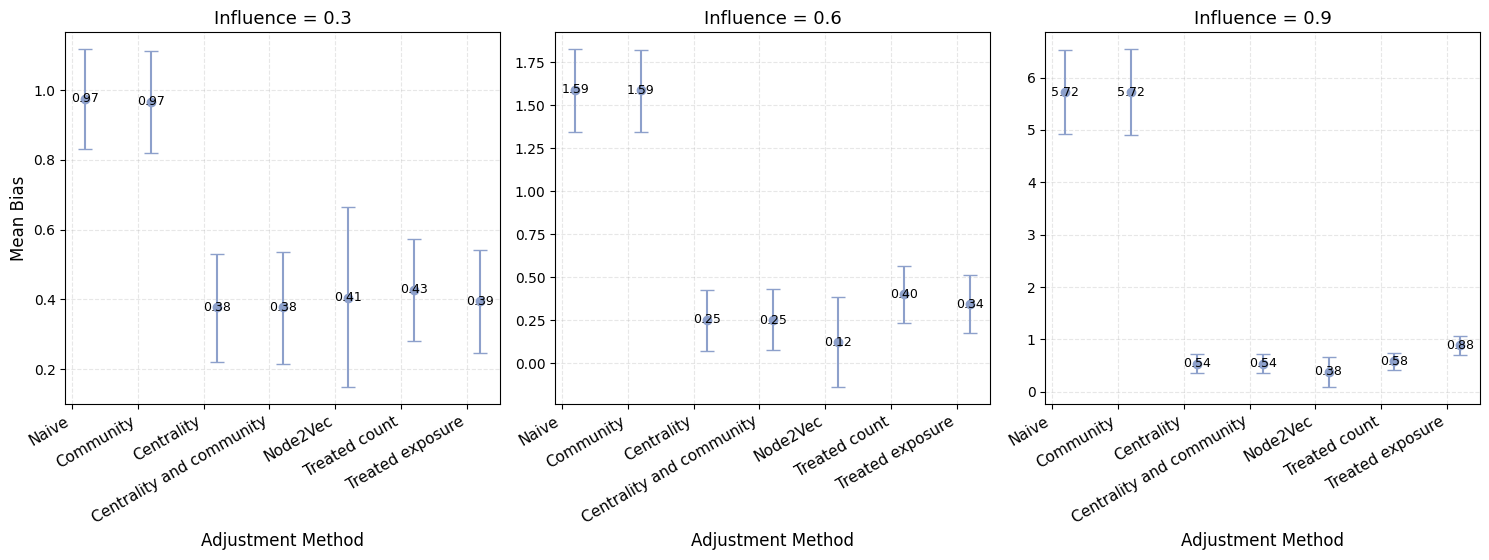

In [55]:
plot_result_graphs_multiple_influence(all_results[all_results["Network"] == "erdos_renyi_graph"])

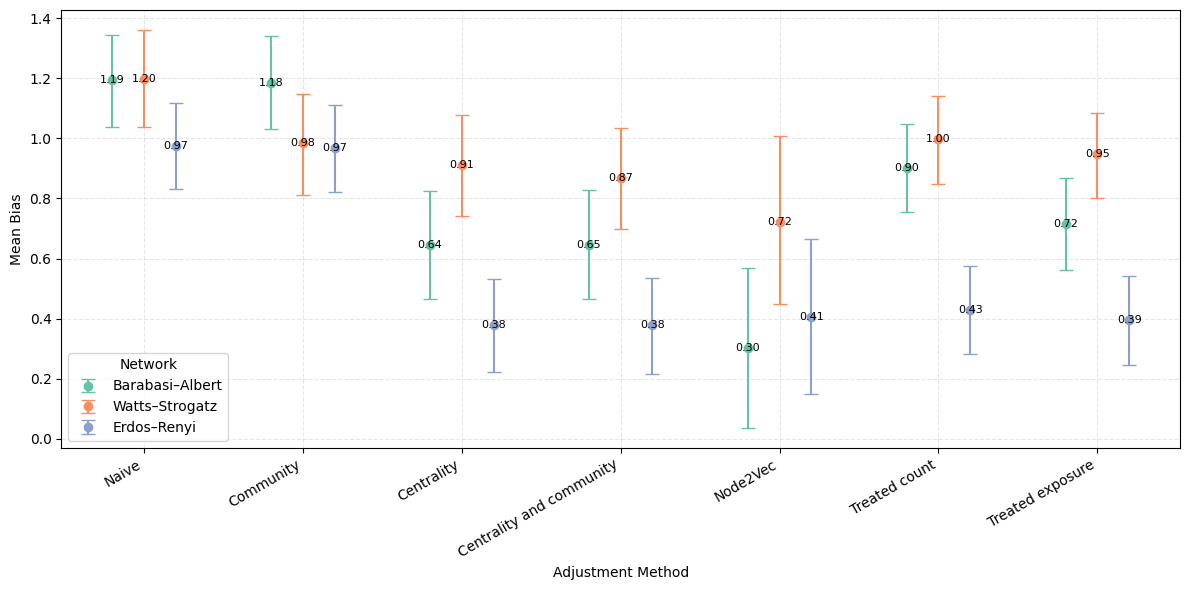

In [28]:
plot_result_graphs(all_results[all_results["Influence"] == 0.3], 0.3)

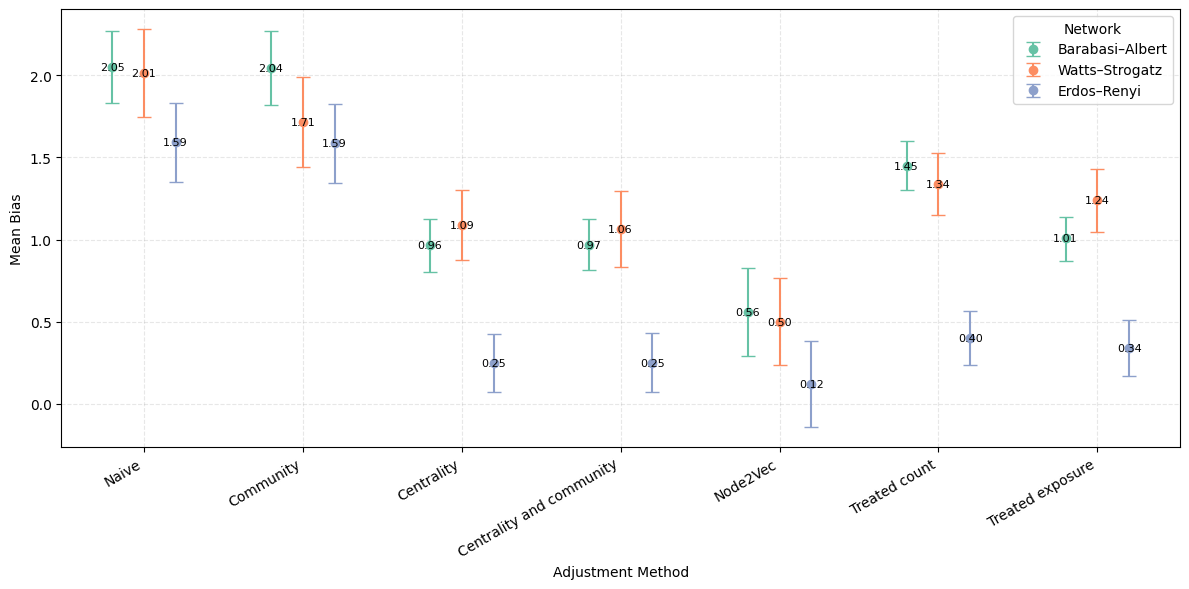

In [26]:
plot_result_graphs(all_results[all_results["Influence"] == 0.6], 0.6)

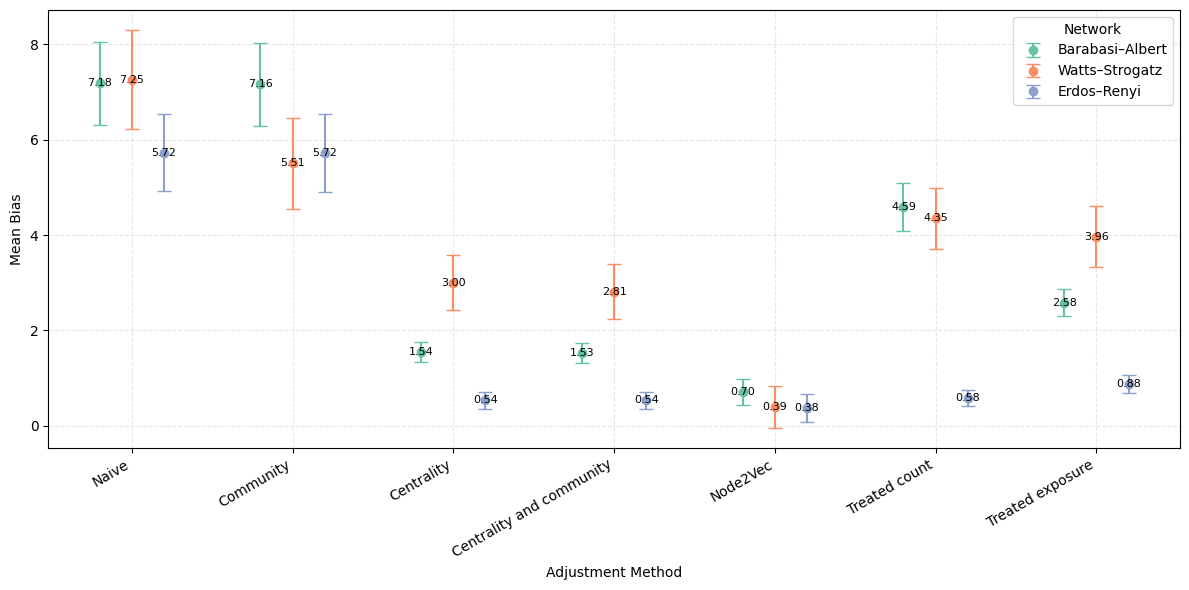

In [27]:
plot_result_graphs(all_results[~all_results["Influence"].isin([0.3, 0.6])], 0.9)

/Users/polinarevina/Desktop/thesis_new/src/methods/visualization.py:217: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plt.ylabel("False Positive Rate (FPR)")
/Users/polinarevina/Desktop/thesis_new/src/methods/visualization.py:217: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  plt.ylabel("False Positive Rate (FPR)")


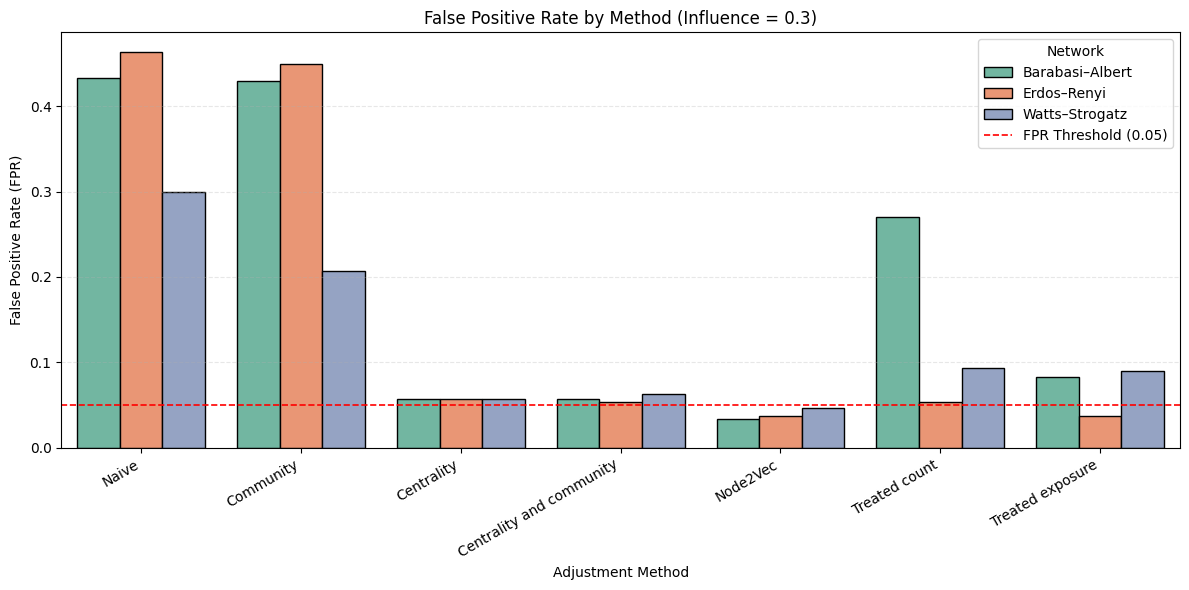

In [31]:
plot_fpr_by_method(all_results, influence=0.3)

/Users/polinarevina/Desktop/thesis_new/src/methods/visualization.py:217: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plt.ylabel("False Positive Rate (FPR)")
/Users/polinarevina/Desktop/thesis_new/src/methods/visualization.py:217: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  plt.ylabel("False Positive Rate (FPR)")


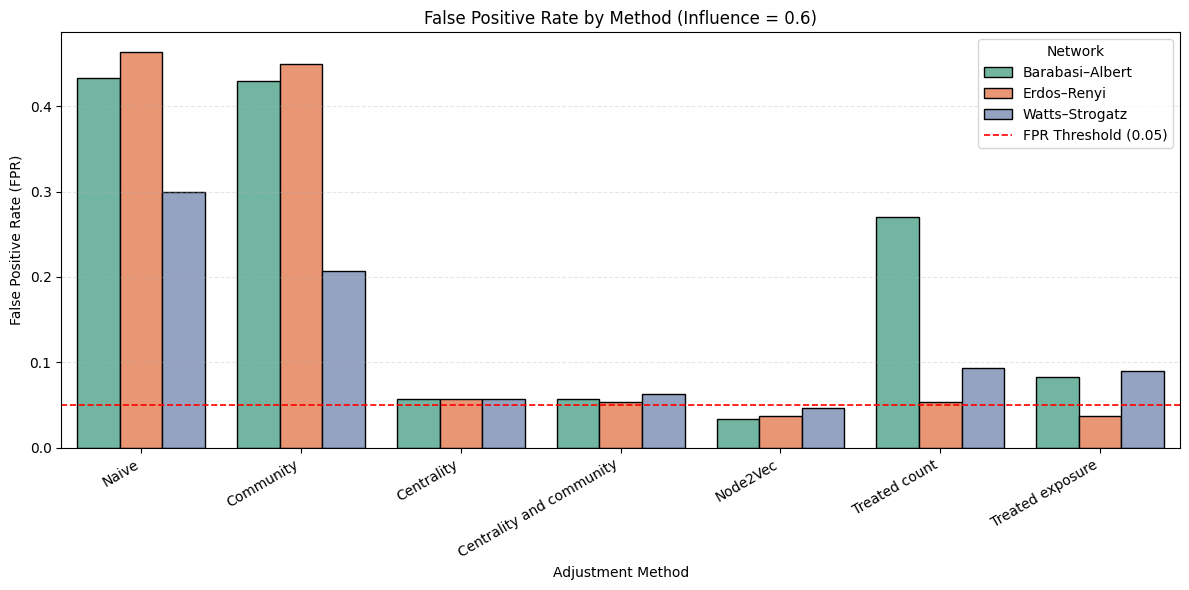

In [32]:
plot_fpr_by_method(all_results, influence=0.6)

/Users/polinarevina/Desktop/thesis_new/src/methods/visualization.py:217: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plt.ylabel("False Positive Rate (FPR)")
/Users/polinarevina/Desktop/thesis_new/src/methods/visualization.py:217: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  plt.ylabel("False Positive Rate (FPR)")


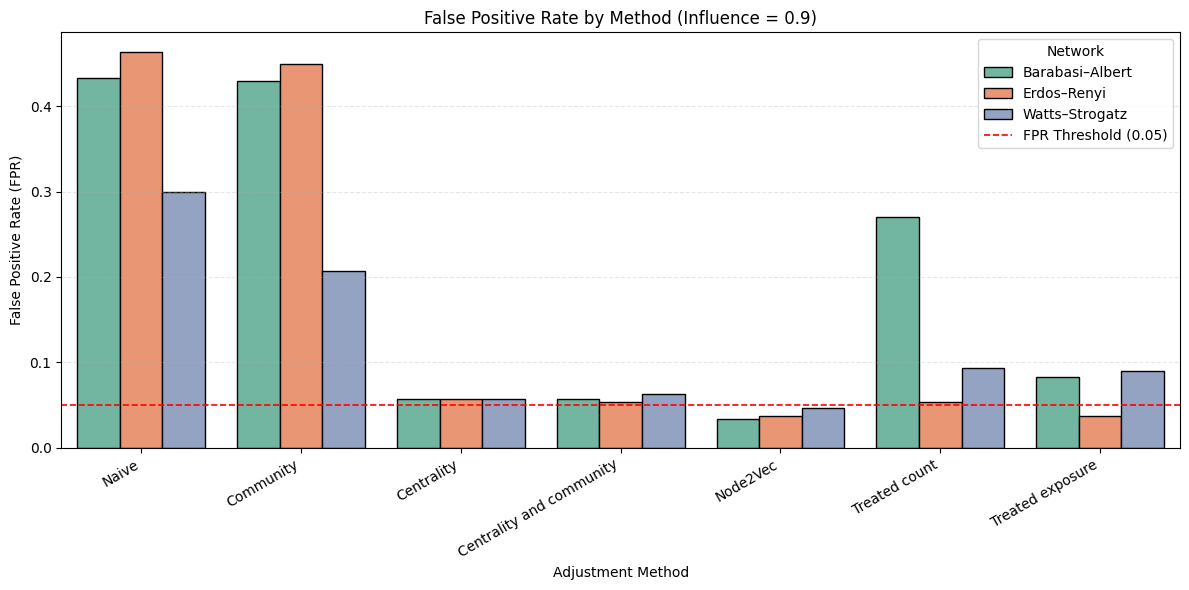

In [33]:
plot_fpr_by_method(all_results, influence=0.9)